In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Hyperparameters
embedding_dimension = 16
latent_dimension = 128
num_colors = 756
num_binary_attributes = 463
input_shape = (256, 256, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
def create_encoder(input_shape):
    inputs = Input(shape=input_shape, name="encoder_input")
    
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(x)
    
    return Model(inputs, [z_mean, z_log_var], name="encoder")

# Decoder
def create_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
    return Model(inputs, outputs, name="decoder")

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        
        # Encode input images
        z_mean, z_log_var = self.encoder(images)
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and VAE model
encoder = create_encoder(input_shape)
decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
vae = VAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = vae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(images, reconstructed_images)
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    return rec_loss, kl_loss

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")


Epoch 1/100


NameError: name 'train_dataset' is not defined

In [89]:
####################read dataset#########################
import os
import random
import pandas as pd

image_folder = "data/img"
#image_files = [(os.path.join(image_folder, f), idx) for idx, f in enumerate(os.listdir(image_folder)) if f.endswith(".jpg")]
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

In [130]:
######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio, val_ratio = 0.6, 0.2

train_files = image_files[:int(total_images * train_ratio)]
val_files = image_files[int(total_images * train_ratio):int(total_images * (train_ratio + val_ratio))]
test_files = image_files[int(total_images * (train_ratio + val_ratio)):]
#print(train_files)
#print(val_files)
#print(test_files)

In [131]:
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)

###################val dataset label##########################
val_ids=[]
for val_index in val_files:
    parts = val_index.split('/')
    val_ids.append(parts[2][:-4])
    
val_labels = pd.DataFrame(columns=item_attr_data.columns)
val_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in val_ids], axis=0, ignore_index=True)

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)

In [51]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [52]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

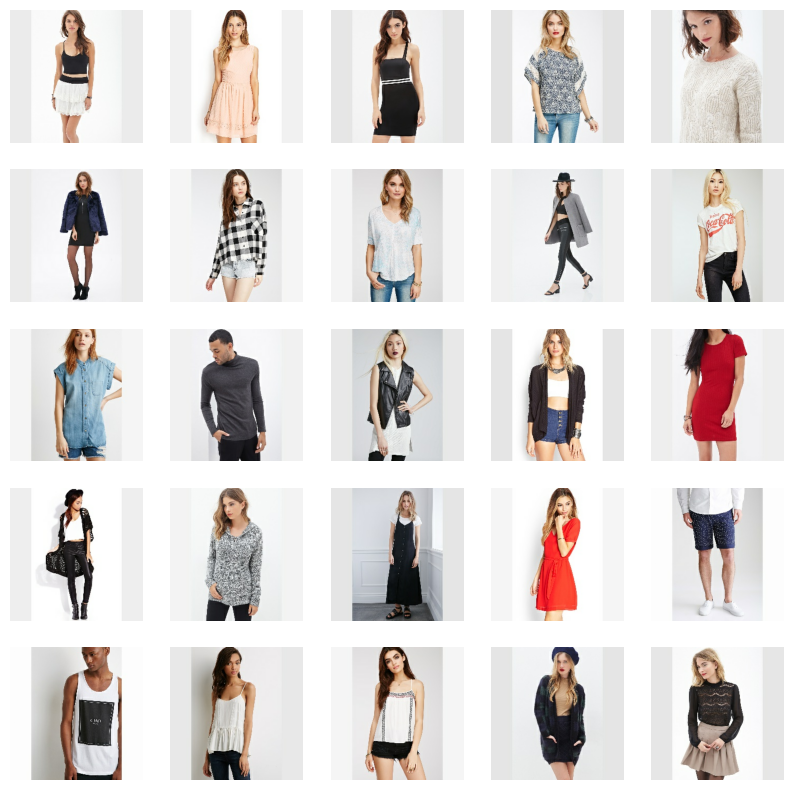

In [53]:
###############visualize the train set image#######################
import matplotlib.pyplot as plt

# Define a function to show the images
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    
# Get the first batch of images from the train_dataset
image_batch = next(iter(train_dataset))

# Show the batch of images
show_batch(image_batch)